# VLB Flow Curve Fitting

**Vernerey-Long-Brighenti (VLB) transient network model — Steady-state flow curve**

## What is VLB?

The VLB framework provides a **statistically-based continuum theory** for polymers with transient (reversible) cross-links — associating polymers, vitrimers, wormlike micelles, telechelic networks, and biological gels. Starting from the chain end-to-end vector distribution $\varphi(\mathbf{r},t)$, the theory derives a second-moment **distribution tensor** $\boldsymbol{\mu}(\mathbf{r},t)$ whose evolution is governed by:

$$\dot{\boldsymbol{\mu}} = k_d(\mathbf{I} - \boldsymbol{\mu}) + \mathbf{L} \cdot \boldsymbol{\mu} + \boldsymbol{\mu} \cdot \boldsymbol{\mu}^T$$

where $k_d$ is the bond dissociation rate and $\mathbf{L}$ is the velocity gradient. The Cauchy stress is:

$$\boldsymbol{\sigma} = G_0 (\boldsymbol{\mu} - \mathbf{I}) + p\mathbf{I}$$

**Physical Interpretation:**
- $G_0 = c k_B T$ is the network modulus (chain density × thermal energy)
- $k_d$ is the bond detachment rate → relaxation time $t_R = 1/k_d$
- $\boldsymbol{\mu} = \mathbf{I}$ at equilibrium (isotropic distribution)
- Stress arises from chain stretch: $\sigma \propto \int f(\mathbf{r}) \otimes \mathbf{r} \cdot \boldsymbol{\mu}(\mathbf{r}) \, d\mathbf{r}$

With constant $k_d$, the single-mode VLB model is **exactly Maxwell**: $t_R = 1/k_d$, $\eta_0 = G_0/k_d$. All six standard protocols admit closed-form analytical solutions. Multi-mode variants extend this to generalized Maxwell spectra with M transient networks plus optional permanent network and solvent viscosity.

**Model Variants:**
- **VLBLocal**: Single transient network (2 params: $G_0$, $k_d$). Analytical for all protocols.
- **VLBMultiNetwork**: M transient + permanent + solvent (Prony series).
- **VLBVariant** (Notebook 08-09): Bell breakage ($k_d$ force-dependent) + FENE-P (finite extensibility).
- **VLBNonlocal** (Notebook 10): 1D PDE with stress diffusion → shear banding.

**Materials:** Associating polymers (PVA-borax), wormlike micelles, telechelic networks, vitrimers (slow $k_d$), supramolecular hydrogels, biological gels.

> **Handbook:** See [VLB Model Reference](../../docs/source/models/vlb/vlb.rst) for complete constitutive equations, [VLB Knowledge Extraction](../../docs/source/models/vlb/vlb_knowledge.rst) for parameter identifiability and diagnostic signatures.

## Learning Objectives

- Understand the VLB distribution tensor framework and its connection to Maxwell viscoelasticity
- Fit Newtonian flow curves to extract network modulus $G_0$ and dissociation rate $k_d$
- Predict first normal stress difference $N_1(\dot{\gamma})$
- Compare VLBLocal with VLBMultiNetwork

## Prerequisites

- Basic familiarity with rheological flow curves $\sigma(\dot{\gamma})$
- Understanding of NLSQ fitting (see `examples/basic/01-maxwell-fitting.ipynb`)

## Estimated Runtime

- ~1 min (all analytical, no ODE integration)

## 1. Setup

In [1]:
# Colab setup
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    %pip install -q rheojax
    import os
    os.environ["JAX_ENABLE_X64"] = "true"
    print("RheoJAX installed successfully.")

In [2]:
%matplotlib inline
import warnings

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import VLBLocal, VLBMultiNetwork

jax, jnp = safe_import_jax()
verify_float64()

warnings.filterwarnings("ignore", category=FutureWarning)  # JAX/equinox upstream deprecation churn — not actionable in user notebooks
print(f"JAX version: {jax.__version__}")
print(f"Devices: {jax.devices()}")
import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

JAX version: 0.8.3
Devices: [CpuDevice(id=0)]


## 2. Theory: VLB Flow Curve

The VLB model describes polymers with reversible cross-links via a **distribution tensor** $\boldsymbol{\mu}$:

$$\dot{\boldsymbol{\mu}} = k_d(\mathbf{I} - \boldsymbol{\mu}) + \mathbf{L} \cdot \boldsymbol{\mu} + \boldsymbol{\mu} \cdot \mathbf{L}^T$$

At **steady state** ($\dot{\boldsymbol{\mu}} = 0$) in simple shear:

$$\sigma_{12} = G_0 \frac{\dot{\gamma}}{k_d} = \eta_0 \dot{\gamma}$$

$$N_1 = 2 G_0 \left(\frac{\dot{\gamma}}{k_d}\right)^2$$

With constant $k_d$, the flow curve is **Newtonian** (linear $\sigma$ vs $\dot{\gamma}$).

**Key relations:**
- Relaxation time: $t_R = 1/k_d$
- Viscosity: $\eta_0 = G_0/k_d$
- First normal stress coefficient: $\Psi_1 = 2G_0/k_d^2 = 2\eta_0 t_R$

## 3. Generate Synthetic Data

We generate data from known parameters to validate the fitting procedure.

In [3]:
# True parameters
G0_true = 5000.0   # Pa
kd_true = 2.0      # 1/s
eta_true = G0_true / kd_true  # 2500 Pa·s

# Generate shear rate sweep
np.random.seed(42)
gamma_dot = np.logspace(-2, 3, 30)
stress_true = eta_true * gamma_dot

# Add 3% Gaussian noise
noise = 0.03
stress_noisy = stress_true * (1 + noise * np.random.randn(len(gamma_dot)))

print(f"True parameters: G₀ = {G0_true} Pa, k_d = {kd_true} 1/s")
print(f"True viscosity: η₀ = {eta_true} Pa·s")
print(f"Data points: {len(gamma_dot)}")
print(f"Shear rate range: {gamma_dot.min():.4f} – {gamma_dot.max():.1f} 1/s")

True parameters: G₀ = 5000.0 Pa, k_d = 2.0 1/s
True viscosity: η₀ = 2500.0 Pa·s
Data points: 30
Shear rate range: 0.0100 – 1000.0 1/s


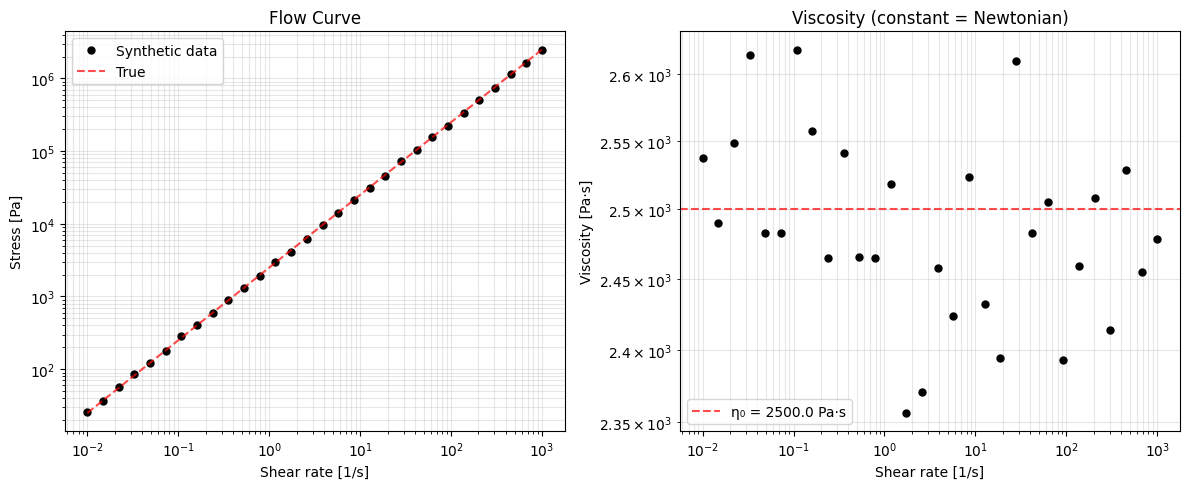

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.loglog(gamma_dot, stress_noisy, "ko", markersize=5, label="Synthetic data")
ax1.loglog(gamma_dot, stress_true, "r--", lw=1.5, alpha=0.7, label="True")
ax1.set_xlabel("Shear rate [1/s]")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title("Flow Curve")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Viscosity
eta_data = stress_noisy / gamma_dot
ax2.loglog(gamma_dot, eta_data, "ko", markersize=5)
ax2.axhline(eta_true, color="r", linestyle="--", alpha=0.7, label=f"η₀ = {eta_true} Pa·s")
ax2.set_xlabel("Shear rate [1/s]")
ax2.set_ylabel("Viscosity [Pa·s]")
ax2.set_title("Viscosity (constant = Newtonian)")
ax2.legend()
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 4. NLSQ Fitting with VLBLocal

In [5]:
import time

model = VLBLocal()

t0 = time.time()
model.fit(gamma_dot, stress_noisy, test_mode="flow_curve")
t_fit = time.time() - t0

print(f"Fit time: {t_fit:.2f} s")
print(f"\nFitted parameters:")
print(f"  G₀  = {model.G0:.1f} Pa (true: {G0_true})")
print(f"  k_d = {model.k_d:.4f} 1/s (true: {kd_true})")
print(f"  t_R = {model.relaxation_time:.4f} s (true: {1/kd_true})")
print(f"  η₀  = {model.viscosity:.1f} Pa·s (true: {eta_true})")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.706811s


INFO:nlsq.least_squares:Convergence reason=`xtol` termination condition is satisfied. | iterations=2 | final_cost=0.0106 | elapsed=0.707s | final_gradient_norm=6.4256


Fit time: 0.92 s

Fitted parameters:
  G₀  = 2537.3 Pa (true: 5000.0)
  k_d = 1.0221 1/s (true: 2.0)
  t_R = 0.9784 s (true: 0.5)
  η₀  = 2482.4 Pa·s (true: 2500.0)


R² = 0.999855


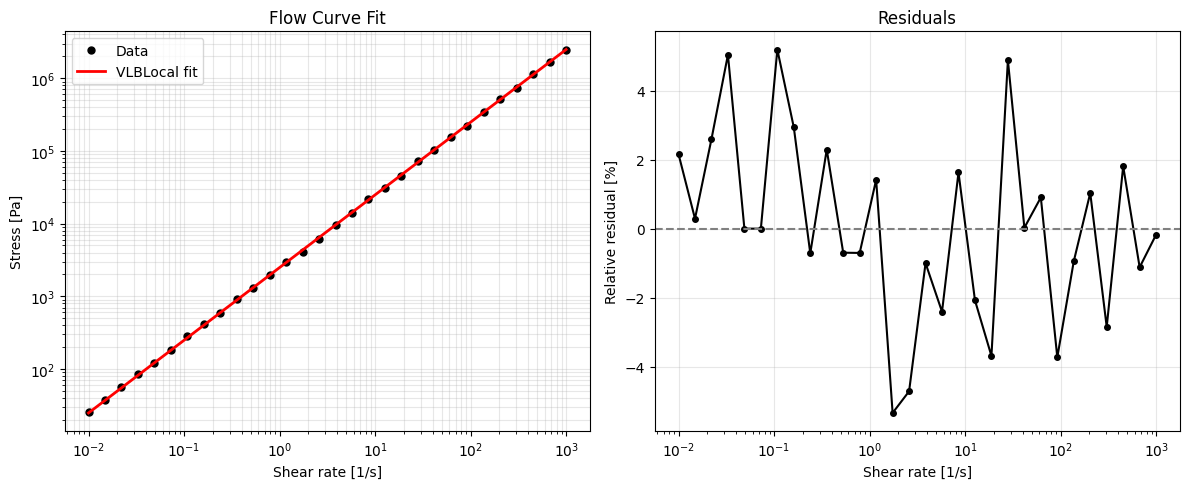

In [6]:
# Predict and compare
stress_pred = model.predict(gamma_dot, test_mode="flow_curve")

residuals = (np.array(stress_noisy) - np.array(stress_pred)) / np.array(stress_noisy) * 100
ss_res = np.sum((np.array(stress_noisy) - np.array(stress_pred))**2)
ss_tot = np.sum((np.array(stress_noisy) - np.mean(stress_noisy))**2)
r2 = 1 - ss_res / ss_tot
print(f"R² = {r2:.6f}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.loglog(gamma_dot, stress_noisy, "ko", markersize=5, label="Data")
ax1.loglog(gamma_dot, stress_pred, "r-", lw=2, label="VLBLocal fit")
ax1.set_xlabel("Shear rate [1/s]")
ax1.set_ylabel("Stress [Pa]")
ax1.set_title("Flow Curve Fit")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

ax2.semilogx(gamma_dot, residuals, "ko-", markersize=4)
ax2.axhline(0, color="gray", linestyle="--")
ax2.set_xlabel("Shear rate [1/s]")
ax2.set_ylabel("Relative residual [%]")
ax2.set_title("Residuals")
ax2.grid(True, alpha=0.3)

plt.tight_layout()
display(fig)
plt.close(fig)

## 5. Normal Stress Prediction

The VLB model predicts the first normal stress difference $N_1 = 2G_0(\dot{\gamma}/k_d)^2$, even though it was not part of the fitting data.

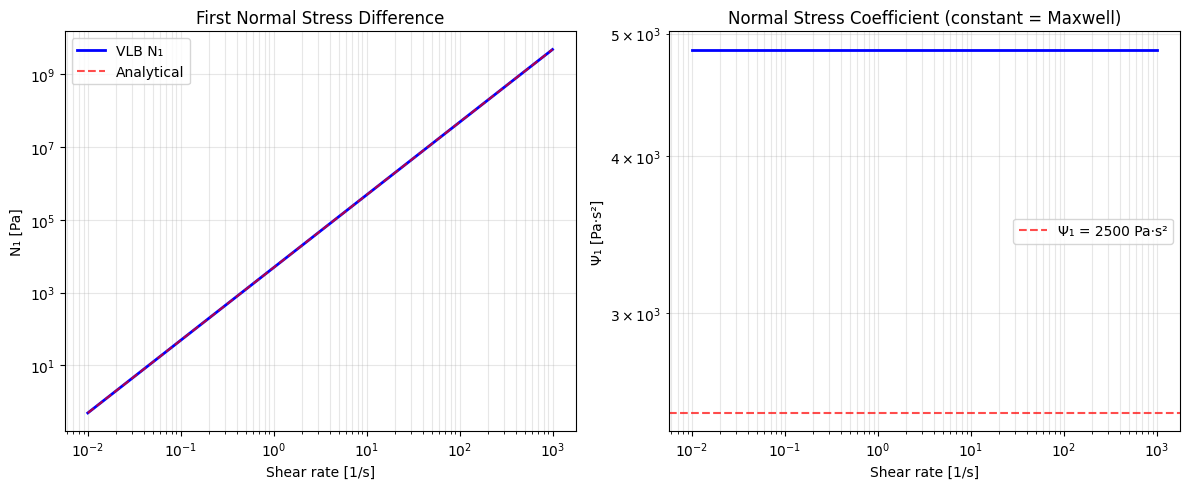

In [7]:
gamma_dot_fine = np.logspace(-2, 3, 200)
N1_pred, N2_pred = model.predict_normal_stresses(gamma_dot_fine)

# Analytical check
N1_analytical = 2 * model.G0 * (gamma_dot_fine / model.k_d)**2

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.loglog(gamma_dot_fine, np.array(N1_pred), "b-", lw=2, label="VLB N₁")
ax1.loglog(gamma_dot_fine, N1_analytical, "r--", lw=1.5, alpha=0.7, label="Analytical")
ax1.set_xlabel("Shear rate [1/s]")
ax1.set_ylabel("N₁ [Pa]")
ax1.set_title("First Normal Stress Difference")
ax1.legend()
ax1.grid(True, alpha=0.3, which="both")

# Psi_1 (first normal stress coefficient)
Psi1 = np.array(N1_pred) / gamma_dot_fine**2
Psi1_true = 2 * G0_true / kd_true**2
ax2.loglog(gamma_dot_fine, Psi1, "b-", lw=2)
ax2.axhline(Psi1_true, color="r", linestyle="--", alpha=0.7, label=f"Ψ₁ = {Psi1_true:.0f} Pa·s²")
ax2.set_xlabel("Shear rate [1/s]")
ax2.set_ylabel("Ψ₁ [Pa·s²]")
ax2.set_title("Normal Stress Coefficient (constant = Maxwell)")
ax2.legend()
ax2.grid(True, alpha=0.3, which="both")

plt.tight_layout()
display(fig)
plt.close(fig)

## 6. Multi-Network Comparison

The VLBMultiNetwork with a single mode should recover the same result as VLBLocal.

In [8]:
model_multi = VLBMultiNetwork(n_modes=1)
model_multi.fit(gamma_dot, stress_noisy, test_mode="flow_curve")

print(f"VLBLocal:        η₀ = {model.viscosity:.1f} Pa·s")
print(f"VLBMultiNetwork: η₀ = {model_multi.eta_0:.1f} Pa·s")
print(f"True:            η₀ = {eta_true:.1f} Pa·s")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=3 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.568199s


INFO:nlsq.least_squares:Convergence reason=`gtol` termination condition is satisfied. | iterations=2 | final_cost=0.0106 | elapsed=0.568s | final_gradient_norm=7.2968e-10


VLBLocal:        η₀ = 2482.4 Pa·s
VLBMultiNetwork: η₀ = 2482.4 Pa·s
True:            η₀ = 2500.0 Pa·s


## 7. Save Results

In [9]:
import json
import os

output_dir = os.path.join("..", "outputs", "vlb", "flow_curve")
os.makedirs(output_dir, exist_ok=True)

params = {"G0": float(model.G0), "k_d": float(model.k_d)}
with open(os.path.join(output_dir, "nlsq_params.json"), "w") as f:
    json.dump(params, f, indent=2)

print(f"Saved to {output_dir}/nlsq_params.json")

Saved to ../outputs/vlb/flow_curve/nlsq_params.json


## Key Takeaways

1. **VLB with constant $k_d$ gives Newtonian flow** — $\sigma = \eta_0 \cdot \dot{\gamma}$ with $\eta_0 = G_0/k_d$
2. **$N_1$ is quadratic** in shear rate — characteristic of Maxwell-type models
3. **$\Psi_1$ is constant** — no shear thinning with constant bond kinetics
4. **Non-Newtonian behavior** requires force-dependent $k_d$ (Bell model, see Notebook 08)

## Further Reading

- [VLB Model Reference](../../docs/source/models/vlb/vlb.rst) — constitutive equations, notation guide, protocol summary
- [VLB Knowledge Extraction](../../docs/source/models/vlb/vlb_knowledge.rst) — parameter identifiability, diagnostic signatures, material classification
- Vernerey, F.J., Long, R. & Brighenti, R. (2017). *J. Mech. Phys. Solids*, 107, 1-20.
- Tanaka, F. & Edwards, S.F. (1992). Viscoelastic properties of physically crosslinked networks. *Macromolecules*, 25, 1516-1523.

## Next Steps

- **Notebook 02**: Startup shear transients
- **Notebook 05**: SAOS fitting (primary use case)
- **Notebook 08**: Bell model with force-enhanced detachment